<center>
    <h2>
        Deep Learning
    </h2>
    <h3>
        Image Deblurring
    </h3>
</center>

<br>

<b>Student</b>: Matteo Donati <br>
<b>Student ID</b>: 0001032227 <br>
<b>E-mail</b>: matteo.donati10@studio.unibo.it

<br>

The aim of this notebook is to present a solution to the proposed image deblurring task. In particular, to solve such problem (up to a certain MSE score and a certain accuracy), a specific neural network (namely a U-Net) has been implemented and trained by using the provided training set. Moreover, the performances of the model have been measured by computing the mean squared error (MSE) between the predicted set of images and the given test set of images. Based on the achieved results, the final MSE score on the provided test set is $0.002185386799743028$.

Please note that the execution of all the cells in this notebook takes, approximately, twenty minutes and requires a dedicated GPU.

### Table of Contents

* [Libraries](#libraries)
* [Dataset Creation](#dataset_creation)
* [Model Definition](#model_definition)
* [Model Fitting](#model_fitting)
* [Results](#results)

### Libraries <a name="libraries"></a>

In this section, the main libraries have been imported.

In [ ]:
# Importing tensorflow.
import tensorflow as tf

# Importing numpy.
import numpy as np

# Importing random.
import random

# Importing GaussianBlur.
from cv2 import GaussianBlur

# Importing pyplot.
from matplotlib import pyplot as plt

# Importing models, layers, losses.
from keras import models, layers, losses

### Dataset Creation <a name="dataset_creation"></a>

In order to load the entire dataset, the `getDataset` function has been provided. This function implements the following steps:

1. It stores the training and testing set of images of CIFAR-10.
2. It normalizes the above-mentioned sets.
3. It applies Gaussian blur as well as Gaussian noise to the aforementioned sets.
4. It returns both the original sets as well as the modified sets.

In [ ]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

Given the `getDataset` function, the entire dataset is loaded and split into different subsets:

* `x_train`, which stores the training blurred images.
* `y_train`, which stores the training original images.
* `x_test`, which stores the testing blurred images.
* `y_test`, which stores the testing original images.

In [ ]:
# Downloading train and test data using the provided function.
train, test = getDataset()

# Storing the blurred training images.
x_train = train[0]

# Storing the original training images.
y_train = train[1]

# Storing the blurred testing images.
x_test = test[0]

# Storing the original testing images.
y_test = test[1]

# Printing the shapes of the computed training sets.
print("x_train's shape: {}, y_train's shape: {}.".format(x_train.shape, y_train.shape))

# Printing the shapes of the computed testing sets.
print("x_test's shape: {}, y_test's shape: {}.".format(x_test.shape, y_test.shape))

170508288/170498071 [==============================] - 13s 0us/step
x_train's shape: (50000, 32, 32, 3), y_train's shape: (50000, 32, 32, 3).
x_test's shape: (10000, 32, 32, 3), y_test's shape: (10000, 32, 32, 3).


Due to the application of Gaussian blur and of Gaussian noise, the `x_train` and `x_test` sets contain multiple images whose maximum and minimum values are, respectively, greater than $1$ and smaller than $0$. Indeed, when one tries to plot such images, one always encounters the following warning:

`Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).`

However, it has been decided to not modify, in any way, the provided dataset.

In [ ]:
# Printing the maximum value which can be found in each set.
print("x_train's max: {:.3f}, y_train's max: {:.3f}, x_test's max: {:.3f}, y_test's max: {:.3f}.".format(np.max(x_train), np.max(y_train), np.max(x_test), np.max(y_test)))

# Printing the minimum value which can be found in each set.
print("x_train's min: {:.3f}, y_train's min: {:.3f}, x_test's min: {:.3f}, y_test's min: {:.3f}.".format(np.min(x_train), np.min(y_train), np.min(x_test), np.min(y_test)))

x_train's max: 1.096, y_train's max: 1.000, x_test's max: 1.103, y_test's max: 1.000.
x_train's min: -0.094, y_train's min: 0.000, x_test's min: -0.081, y_test's min: 0.000.


In the following code cell, the first five training images are plotted. In particular, the first row contains the first five `x_train`'s images, while the second row contains the first five `y_train`'s images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


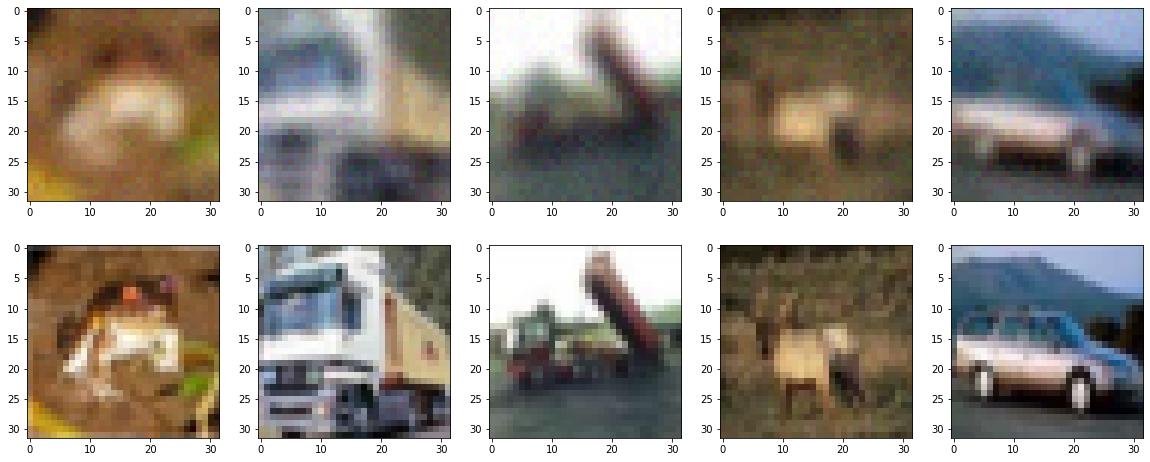

In [ ]:
# Defining the number of images to be shown.
N_IMAGES = 5

# Plotting a bunch of retrieved training images.
fig, axs = plt.subplots(2, N_IMAGES, figsize = (4 * N_IMAGES, 8))

# Iterating over columns.
for i in range(N_IMAGES):

  # Plotting the input training image.
  axs[0, i].imshow(x_train[i])

  # Plotting the target training image.
  axs[1, i].imshow(y_train[i])

# Showing the images.
plt.show();

During the development of the solution, data preprocessing has been given a try. In particular, data preprocessing consisted in filtering both the `x_train` and the `x_test` sets of images using a bilateral filter, which allows one to remove Gaussian noise without blurring edges, so to avoid over-smoothing of the input images. However, it turned out that this particular type of preprocessing, i.e. noise removal, does not help improving the final performances of the model, both in terms of accuracy and of MSE score. Therefore, data preprocessing has not been implemented in the final version of this notebook, thus preferring a more elegant end-to-end type of training.

### Model Definition <a name="model_definition"></a>

In order to tackle the proposed image deblurring problem, a U-Net<sup>[[1]](#references)</sup> has been used. In particular, U-Net is a well-known type of neural network which is largely used for solving image segmentation tasks. This network is composed of both an encoder and a decoder, where the former one is able to extract features from the input image, while the latter one aims at constructing the desired output image, starting from the features which have been extracted by the encoder, and which are a representation of the input image in a specific latent space.

More specifically:

* The encoder part is composed of multiple floors, where each floor implements multiple convolutions. Consecutive floors are connected by a down-sampling operator (e.g. max-pooling, convolution with a stride greater than one, sub-pixel convolution). Moreover, deeper floors usually use more channels than shallow floors.

* The decoder part is composed of multiple floors, where each floor implements multiple convolutions. Consecutive floors are connected by an up-sampling operator (e.g. transposed convolution with a stride greater than one). Moreover, deeper floors usually use more channels than shallow floors.

* Both the encoder and the decoder share the same number of floors. Moreover, the output of each floor of the encoder is concatenated to the input of the corresponding floor of the decoder. This is usually done to avoid the vanishing gradient problem. Indeed, during the application of backpropagation, if one multiplies many very small values together, then the resulting gradient will be very small. Thus, the gradient becomes very small as one approaches the earlier layers in a deep architecture. In some cases, the gradient becomes zero, meaning that one does not update the early layers at all. By using skip connections, one can provide an alternative path for the gradient so to effectively update the parameters of the first layers.

* All the convolutional layers present a ReLU activation function, except for the output convolutional layer, which instead uses a sigmoid activation function, so to produce an output image whose pixels assume a value in $\mathbb{R}_{[0, 1]}$.

The original paper introduces a specific model used to solve segmentation tasks, thus the output layer produces an image which shows a single channel. However, the general structure of the network can be also used to tackle image regression tasks, such as image deblurring and image denoising<sup>[[2]](#references)</sup><sup>[[3]](#references)</sup><sup>[[4]](#references)</sup>.

The following `build_model` function allows one to define the specific U-Net model.

In [ ]:
# Function which allows the creation of a U-Net-like model.
def build_model(input_shape, n_channels, n_floors, conv_per_floor):

  """
  Function which allows the creation of a U-Net-like model.

  Parameters
  ----------
  input_shape : tuple
      The shape of the model's input.
  n_channels : int
      The number of initial channels.
  n_floors : int
      The number of model's floors.
  conv_per_floor : int
      The number of convolutions per floor.

  Returns
  -------
  models.Model(x, y) : keras.engine.functional.Functional
      The neural network.
  """

  # Adding the input layer.
  x = layers.Input(shape = input_shape)

  # List which contains backups of some layers. This will be used to implement the skip connections.
  backup_layers = []

  # Temporary variable which is used to create the network.
  tmp = x

  # Iterating over floors. Descending portion of the network.
  for f in range(n_floors):

    # Iterating over the number of convolutions per floor.
    for c in range(conv_per_floor):
      
      # Adding a 2D convolutional layer.
      tmp = layers.Conv2D(n_channels, kernel_size = 3, strides = 1, padding = "same", activation = "relu")(tmp)

    # Checking if the current floor is not the last floor.
    if f < n_floors - 1:

      # Appending tmp to the backup_layers.
      backup_layers.append(tmp)

      # Adding a 2D convolutional layer for down-sampling.
      tmp = layers.Conv2D(n_channels, kernel_size = 3, strides = 2, padding = "same", activation = "relu")(tmp)

      # Updating the number of channels.
      n_channels = n_channels * 2
  
  # Iterating over floors. Ascending portion of the network.
  for f in range(n_floors - 1):

    # Reducing the number of channels.
    n_channels = n_channels // 2

    # Adding a 2D transposed convolutional layer for up-sampling.
    tmp = layers.Conv2DTranspose(n_channels, kernel_size = 3, strides = 2, padding = "same", activation = "relu")(tmp)

    # Concatenating the output of the encoder's floor to the input of the corresponding decoder's floor.
    tmp = layers.concatenate([tmp, backup_layers.pop(-1)])

    # Iterating over the number of convolutions per floor.
    for c in range(conv_per_floor):
      
      # Adding a 2D convolutional layer.
      tmp = layers.Conv2D(n_channels, kernel_size = 3, strides = 1, padding = "same", activation = "relu")(tmp)
      
  # Adding the final 2D convolutional layer in order to obtain a (32, 32, 3) output image.
  y = layers.Conv2D(input_shape[-1], kernel_size = 1, activation = "sigmoid")(tmp)

  # Returning the computed model.
  return models.Model(x, y)

In particular, the `build_model` function is used to build the following U-Net model:

<br>
<br>

network.svg

<br>

The proposed configuration uses the following parameters:

* An input shape equal to $32 \times 32 \times 3$ (`INPUT_SHAPE`).
* An initial number of channels equal to $64$ (`N_CHANNELS`).
* A total number of floors equal to $4$ (`N_FLOORS`).
* A total number of convolutions per floor equal to $2$ (`N_CONV_PER_FLOOR`).

Moreover, during the development of the solution, the proposed training process has also been repeated using different configurations of the U-Net model (namely, different values for the `N_CHANNELS`, `N_FLOORS` and `N_CONV_PER_FLOOR` variables), as well as other types of encoder-decoder models, such as simple autoencoders without skip connections. However, the proposed configuration is the one which yields the best results.

Lastly, the resulting network is compiled by using `tf.keras.optimizers.Adam` as optimizer and `losses.MeanSquaredError` as loss function. During the development of the solution, the proposed training process has also been repeated using different loss functions, such as the mean absolute error function (MAE) as well as the structure similarity index (SSIM) appropriately modified for dealing with RGB images. However, the proposed loss function is the one which yields the best numerical results.

In [ ]:
# Defining the input shape of the model.
INPUT_SHAPE = x_train[0].shape

# Defining the initial number of channels of the model.
N_CHANNELS = 64

# Defining the number of floors of the model.
N_FLOORS = 4

# Defining the number of convolutions per floor of the model.
N_CONV_PER_FLOOR = 2

# Creating the model
model = build_model(input_shape = INPUT_SHAPE, n_channels = N_CHANNELS, n_floors = N_FLOORS, conv_per_floor = N_CONV_PER_FLOOR)

# Compiling the model
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = losses.MeanSquaredError(), metrics = ["accuracy"])

# Printing the summary of the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

### Model Fitting <a name="model_fitting"></a>



The specific U-Net model is trained for a maximum number of epochs equal to $100$, using a batch size of $32$. The selection of the aforementioned hyper-parameters has been made by iterating the training process while varying such parameters (i.e. by applying a grid search over the possible, and reasonable values). In the end, the proposed configuration is the one which guarantees the best final results.

In order to prevent overfitting and/or to avoid useless training epochs when saturation is reached, an `tf.keras.callbacks.EarlyStopping` callback with `patience` equal to $5$ is defined. This specific callback allows one to stop training when a monitored metric (namely `val_loss`) has stopped improving for exactly five consecutive epochs. Moreover, if training is stopped due to this callback, the weights of the model are restored to the weights computed in the best training epoch.

Lastly, at the end of each epoch, the performances of the network are tested using the provided testing sets (namely `x_test` and `y_test`), so to have a real-time preview of which will be the the final results on such images.

In [ ]:
# Defining the number of training epochs.
N_EPOCHS = 100

# Defining the batch size.
BATCH_SIZE = 32

# Defining the callback patience.
PATIENCE = 5

# Defining the specific callback.
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = PATIENCE, restore_best_weights = True)

# Training the model.
history = model.fit(x_train, y_train, epochs = N_EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_test, y_test), callbacks = [callback])

# Saving the weights of the model.
model.save_weights("Matteo_Donati_0001032227.h5")

Epoch 1/100
1563/1563 [==============================] - 81s 44ms/step - loss: 0.0045 - accuracy: 0.8209 - val_loss: 0.0028 - val_accuracy: 0.8083
Epoch 2/100
1563/1563 [==============================] - 67s 43ms/step - loss: 0.0026 - accuracy: 0.8395 - val_loss: 0.0025 - val_accuracy: 0.8495
Epoch 3/100
1563/1563 [==============================] - 67s 43ms/step - loss: 0.0025 - accuracy: 0.8429 - val_loss: 0.0024 - val_accuracy: 0.8488
Epoch 4/100
1563/1563 [==============================] - 67s 43ms/step - loss: 0.0024 - accuracy: 0.8451 - val_loss: 0.0024 - val_accuracy: 0.8507
Epoch 5/100
1563/1563 [==============================] - 66s 43ms/step - loss: 0.0023 - accuracy: 0.8467 - val_loss: 0.0024 - val_accuracy: 0.8469
Epoch 6/100
1563/1563 [==============================] - 67s 43ms/step - loss: 0.0023 - accuracy: 0.8487 - val_loss: 0.0024 - val_accuracy: 0.8330
Epoch 7/100
1563/1563 [==============================] - 68s 43ms/step - loss: 0.0022 - accuracy: 0.8500 - val_loss: 0

When considering the proposed problem, early stopping has mainly been implemented in order to stop training when saturation is reached. Indeed, the proposed training process has also been repeated using different configurations of the U-Net model (namely, different values for the `N_CHANNELS`, `N_FLOORS` and `N_CONV_PER_FLOOR` variables). However, no cases of bad overfitting were ever observed. This observation leads to the conclusion that the presented problem is, intrinsically and with respect to the given dataset, not particularly subject to overfitting. Indeed, one could also remove the early stopping callback and still be able to avoid bad cases of overfitting.

### Results <a name="results"></a>

Once training has stopped, either because of early stopping or because it reached the maximum number of epochs, the index of the best epoch, i.e. the epoch in which the minimum validation loss has been reached, is computed and printed.

In [ ]:
# Retrieving the index of the best epoch.
best_epoch = np.argmin(history.history["val_loss"]) + 1

# Printing the epoch at which the model weights has been saved.
print("The best epoch is the epoch number {}.".format(best_epoch))

The best epoch is the epoch number 12.


In order to visualize the performances of the network, the loss and the accuracy are plotted. In particular, if training stopped due to early stopping, a vertical red line is shown. This line marks the best epoch and determines at which training iteration the model weights have been saved. 

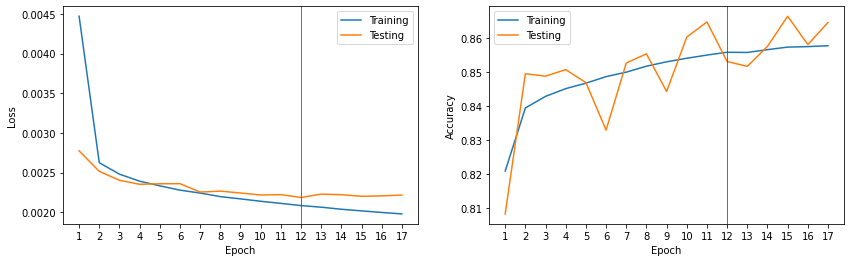

In [ ]:
# Computing the x axis array.
x = np.linspace(1, len(history.history["loss"]), len(history.history["loss"]), dtype = int)

# Creating the figure and axes.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))

# Plotting the model training loss.
ax1.plot(x, history.history["loss"])

# Plotting the model testing loss.
ax1.plot(x, history.history["val_loss"])

# Plotting vertical red line which indicates early stopping.
ax1.axvline(best_epoch, 0, 1, color = "r", linewidth = 0.8)

# Setting labels.
ax1.set_ylabel("Loss")

# Setting labels.
ax1.set_xlabel("Epoch")

# Setting x_ticks.
ax1.set_xticks(x)

# Setting the legend.
ax1.legend(["Training", "Testing"])

# Plotting the model training accuracy.
ax2.plot(x, history.history["accuracy"])

# Plotting the model testing accuracy.
ax2.plot(x, history.history["val_accuracy"])

# Plotting vertical red line which indicates early stopping.
ax2.axvline(best_epoch, 0, 1, color = "r", linewidth = 0.8)

# Setting labels.
ax2.set_ylabel("Accuracy")

# Setting labels.
ax2.set_xlabel("Epoch")

# Setting x_ticks.
ax2.set_xticks(x)

# Setting the legend.
ax2.legend(["Training", "Testing"])

# Showing the plots.
plt.show()

The specific model is then used to predict the original, non-blurred images by taking as input the `x_test` set. Such predictions are stored into the `y_pred` array and will be used, again, to compute the final MSE score.

In [ ]:
# Deblurring test images using the model.
y_pred = model.predict(x_test)

The following cell plots, respectively, the first five images of `x_test` (i.e. the input of the model), the first five images of `y_test` (i.e. the target of the model), and the first five images of `y_pred` (i.e. the predictions of the model). In particular, one can notice how, starting from a generic blurred image, one is able to restore details which had been lost during Guassian filtering.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


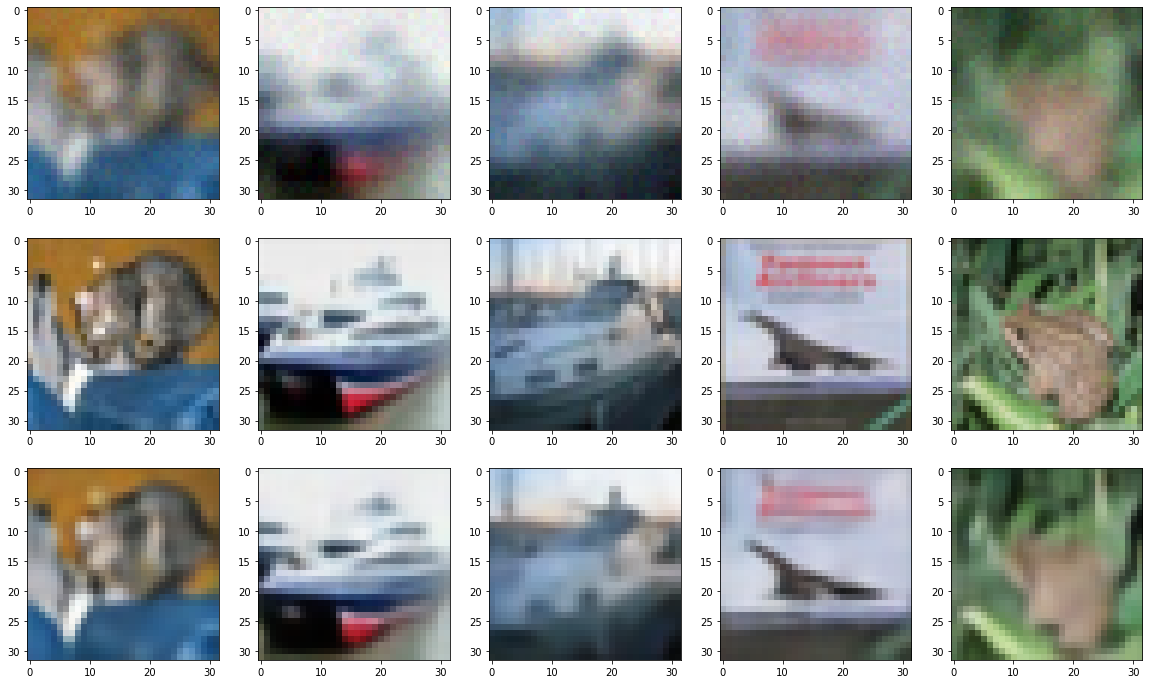

In [ ]:
# Creating the figure and axes.
fig, axs = plt.subplots(3, N_IMAGES, figsize = (4 * N_IMAGES, 12))

# Iterating over columns.
for i in range(N_IMAGES):

  # Plotting the input test image.
  axs[0, i].imshow(x_test[i])

  # Plotting the target test image.
  axs[1, i].imshow(y_test[i])

  # Plotting the predicted image.
  axs[2, i].imshow(y_pred[i])

# Showing the plots.
plt.show()

Lastly, the final MSE score on the testing set is first computed and then printed. In particular, such score is computed by applying the `np.mean` and the `np.square` functions to the difference between `y_test` and `y_pred`.

In [ ]:
# Computing and printing the final MSE score.
print("The MSE score computed on the testing set is: {}.".format(np.mean(np.square(y_test - y_pred))))

The MSE score computed on the testing set is: 0.002185386799743028.


### References <a name="references"></a>

1. Olaf Ronneberger, Philipp Fischer, Thomas Brox, *U-Net: Convolutional Networks for Biomedical Image Segmentation*, DOI: [
https://doi.org/10.48550/arXiv.1505.04597](
https://doi.org/10.48550/arXiv.1505.04597).

2. Sung-Jin Cho, Seo-Won Ji, Jun-Pyo Hong, Seung-Won Jung, Sung-Jea Ko, *Rethinking Coarse-To-Fine Approach in Single Image Deblurring*, DOI: [
https://doi.org/10.48550/arXiv.2108.05054](
https://doi.org/10.48550/arXiv.2108.05054).

3. Chi-Mao Fan, Tsung-Jung Liu, Kuan-Hsien Liu, *SUNet: Swin Transformer UNet for Image Denoising*, DOI: [
https://doi.org/10.48550/arXiv.2202.14009](
https://doi.org/10.48550/arXiv.2202.14009).

4. Yiqing Fan, Chaoqun Hong, Xiaodong Wang, Zhiqiang Zeng, Zetian Guo, *Multi-input-output Fusion Attention Module for Deblurring Networks*, URL: [https://ieeexplore.ieee.org/document/9671844](https://ieeexplore.ieee.org/document/9671844).